# To reproduce a run and investigate seasonal transition signature

In [38]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

sys.path.append("../libs/cfe_py")
from bmi_cfe import BMI_CFE

sys.path.append("../libs/SMSig")
from sig_seasontrans import SMSig

# Specify current directory create output directory if it does not exist
os.getcwd()

'g:\\Shared drives\\Ryoko and Hilary\\SMSigxModel\\analysis\\4_post_analysis'

# Configuration

In [39]:
study_site = "LittleWashita"
case = f"{study_site}-2023-08-29-determine-GW-param-range-NWM\LittleWashita-2023-08-29"
run_id = 1324

In [40]:
data_directory = rf"..\data\{study_site}"
config_temp_path = os.path.join(data_directory, "temporary_parameter_files_for_GLUE", "config_cfe_0.json")
prior_params_path = rf"..\2_GLUE_prerun\results\{case}\prior_parameters.csv"
evaluation_metrics_path = rf"..\2_GLUE_prerun\results\{case}\evaluation_metrics.csv"
out_path = rf".\results\{case}"
if not os.path.exists(out_path):
    os.makedirs(out_path)

# Load parameters for a run

In [41]:
config_all_runs = pd.read_csv(prior_params_path)
config_target_runs = config_all_runs[config_all_runs["run_id"]==run_id]
print(config_target_runs)

      run_id     bb     satdk    satpsi      slop    smcmax    wltsmc  \
1324    1324  6.592  0.000183  0.173624  0.009297  0.976222  0.012947   

      max_gw_storage       Cgw     expon    K_nash    refkdt  trigger_z_fact  \
1324        0.106141  0.000988  3.153968  0.631089  2.496434        0.638118   

      alpha_fc      K_lf  
1324  0.308378  0.573196  


In [42]:
with open(config_temp_path, 'r') as outfile:
    config_temp = json.load(outfile)

In [43]:
for key, value in config_target_runs.items():
    if key == "run_id":
        None
    elif key in ['bb', 'satdk', 'slop', 'satpsi', 'smcmax', 'wltsmc', 'D']:
        config_temp["soil_params"][key] = value.values[0]
    else:
        config_temp[key] = value.values[0]
config_temp

{'forcing_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/LittleWashita/little_washita_2006_2012.csv',
 'catchment_area_km2': 601,
 'soil_params': {'bb': 6.591999812593777,
  'satdk': 0.0001829058209417,
  'slop': 0.0092968319200453,
  'satpsi': 0.1736243088137391,
  'smcmax': 0.9762217502135468,
  'wltsmc': 0.0129467948981879,
  'D': 2},
 'alpha_fc': 0.3083778619066096,
 'max_gw_storage': 0.1061405978955891,
 'Cgw': 0.0009875396369054,
 'expon': 3.153967939163099,
 'K_lf': 0.5731958888031214,
 'refkdt': 2.4964339115813625,
 'K_nash': 0.6310887218737914,
 'trigger_z_fact': 0.6381182019616936,
 'nash_storage': [0.0, 0.0],
 'giuh_ordinates': [0.1, 0.4, 0.2, 0.2, 0.1],
 'stand_alone': 1,
 'unit_test': 1,
 'compare_results_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/LittleWashita/test_sm_basinavg.csv'}

In [44]:
temporary_config_path = "temporary_config_reproducing_run"
if not os.path.exists(temporary_config_path):
    os.makedirs(temporary_config_path)

In [45]:
temporary_config_file = os.path.join(temporary_config_path, f"config_cfe_{run_id}.json")
with open(temporary_config_file, 'w') as out_file:
    json.dump(config_temp, out_file)

# Run CFE

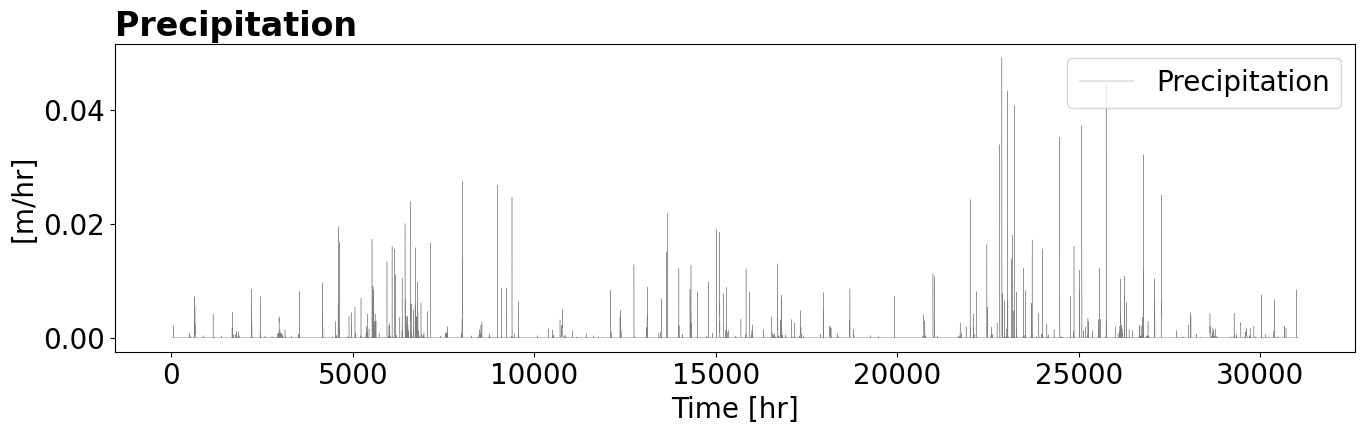

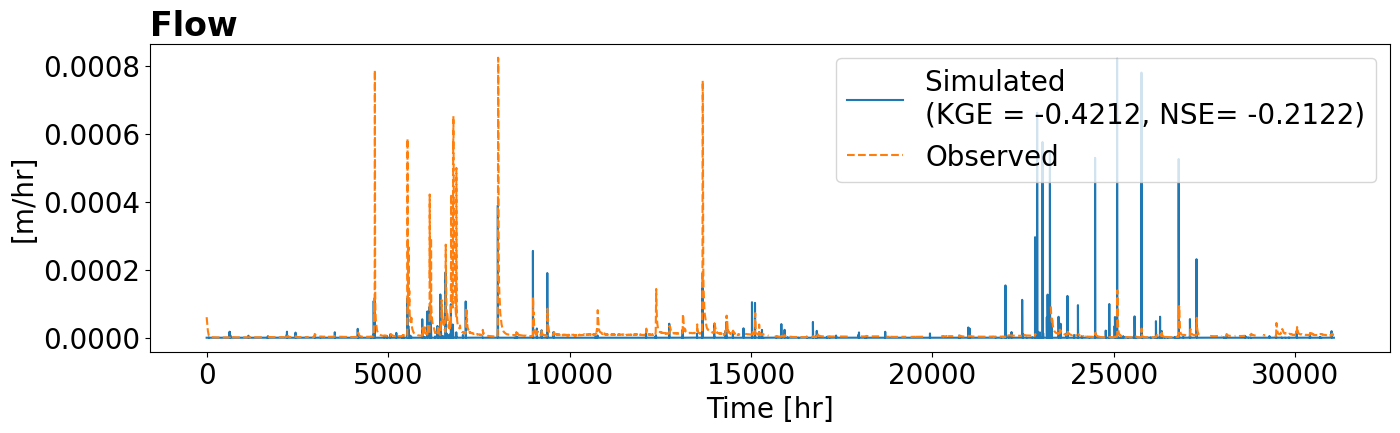

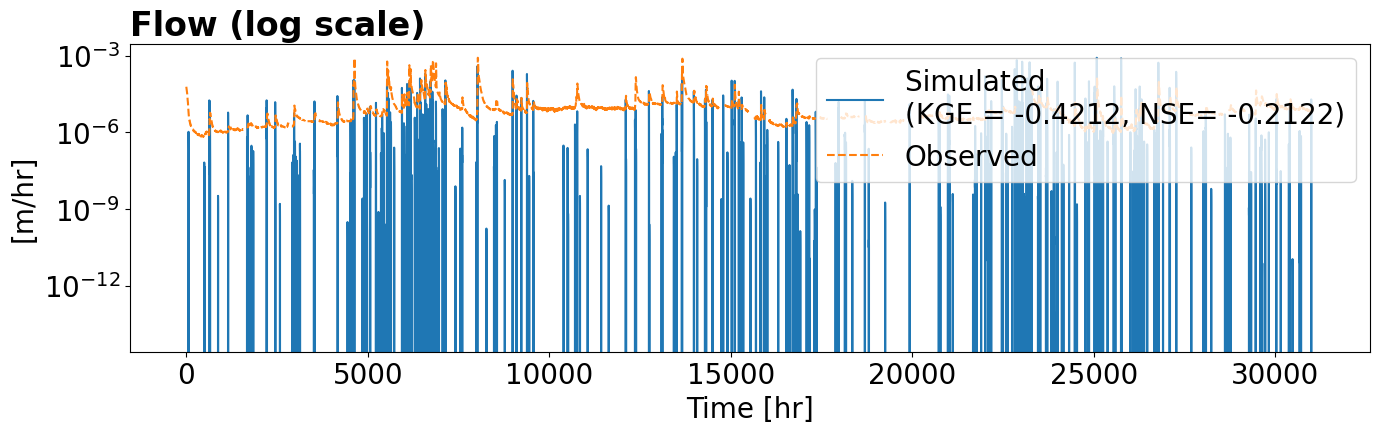

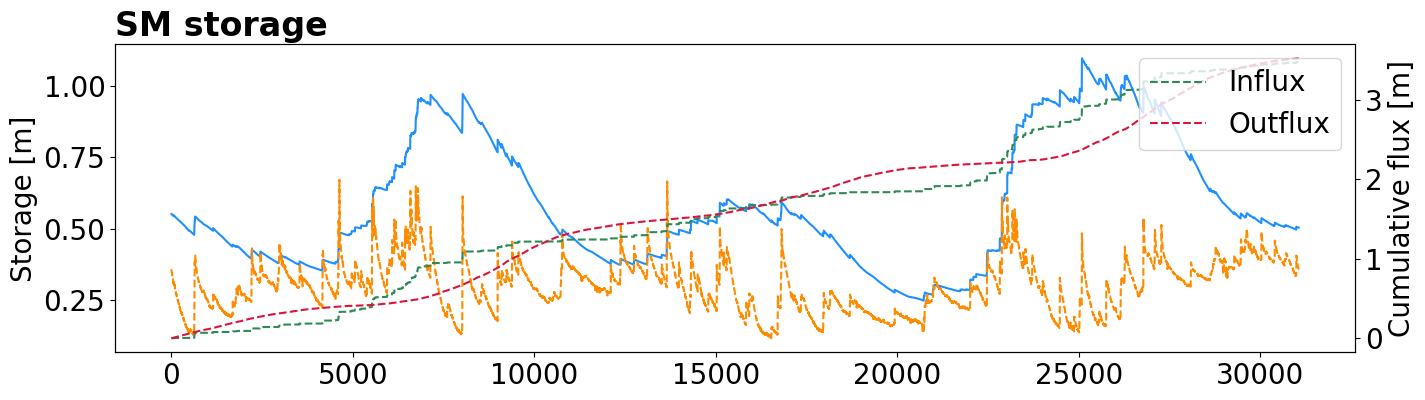

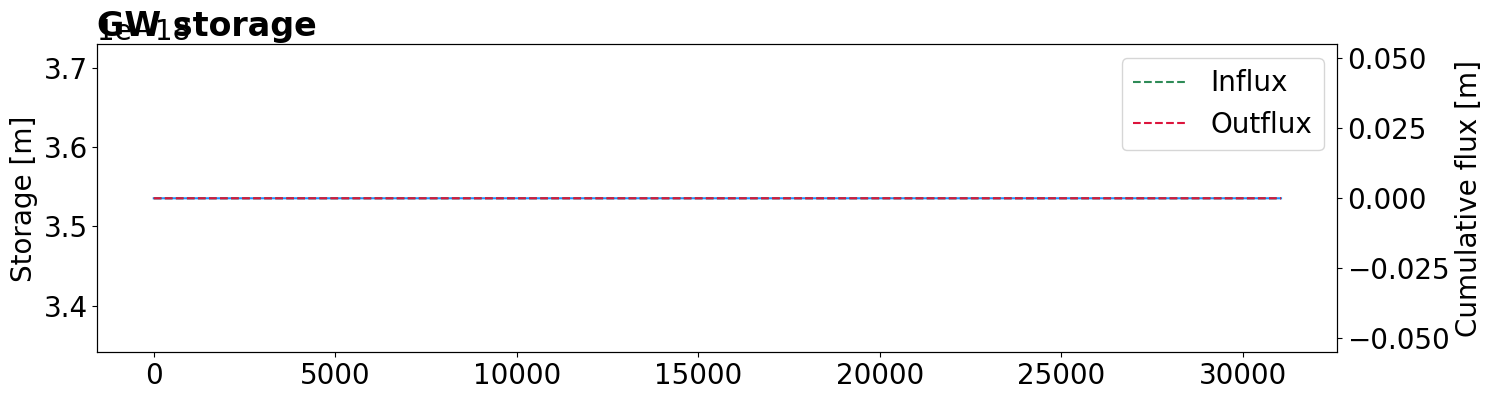

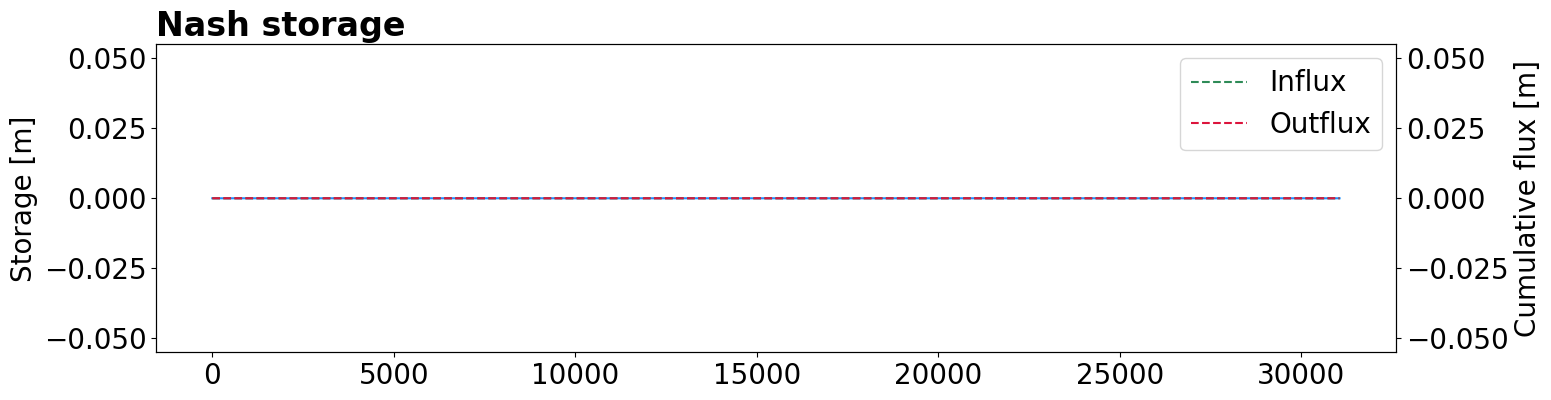

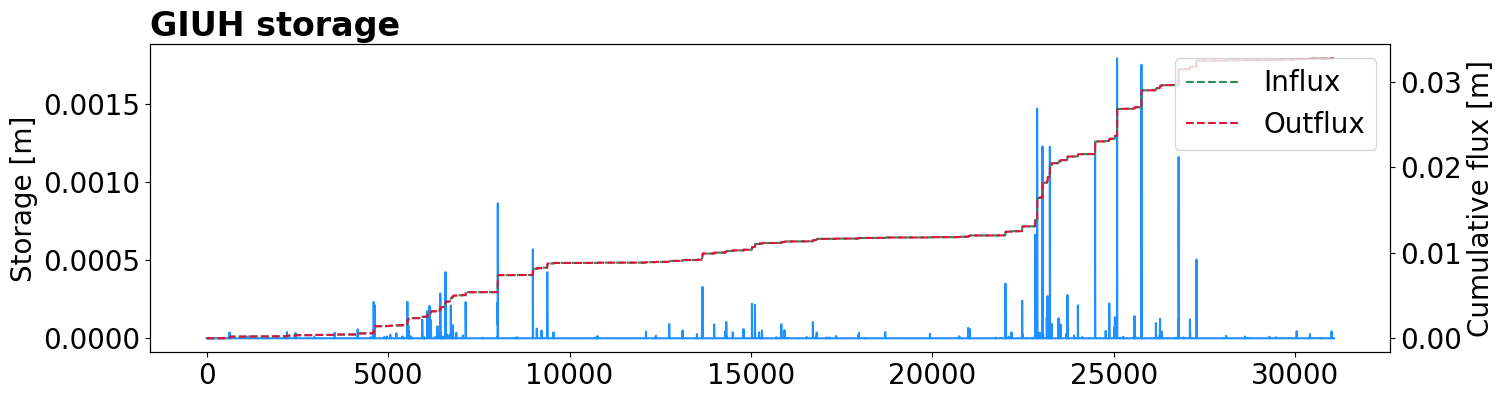

(       Soil Moisture Content
 0                   0.179808
 1                   0.179020
 2                   0.178306
 3                   0.177500
 4                   0.176834
 ...                      ...
 52627               0.085587
 52628               0.085209
 52629               0.085148
 52630               0.085863
 52631               0.085651
 
 [52632 rows x 1 columns],
        Soil Moisture Content
 0                   0.275641
 1                   0.275608
 2                   0.275574
 3                   0.275540
 4                   0.275506
 ...                      ...
 52627               0.214681
 52628               0.214610
 52629               0.214539
 52630               0.214467
 52631               0.214396
 
 [52632 rows x 1 columns])

In [46]:
# Run the CFE based on the config file
cfe_instance = BMI_CFE(temporary_config_file)
cfe_instance.initialize()
sim0 = cfe_instance.run_unit_test(plot=True, warm_up=True)
obs0 = cfe_instance.load_unit_test_data()

# Get the results
var_name = 'Soil Moisture Content'
sim = sim0[["Time", var_name]].copy()
sim["Time"] = pd.to_datetime(sim["Time"], format="%Y-%m-%d %H:%M:%S")  # Works specifically for CFE

# Get the comparison data
obs = obs0[["Time", var_name]].copy()
if study_site == "Mahurangi":
    obs["Time"] = pd.to_datetime(obs["Time"], format="%m/%d/%Y %H:%M")  # Works specifically for Mahurangi data
elif study_site == "LittleWashita":
    obs["Time"] = pd.to_datetime(obs["Time"], format="%Y-%m-%d %H:%M:%S")  # works for Little ashita
# obs["Time"] = pd.to_datetime(obs["Time"], format="%d-%m-%Y %H:%M:%S")

# Merge observed and simulated timeseries
df = pd.merge_asof(sim, obs, on="Time")

sim_synced = pd.DataFrame()
obs_synced = pd.DataFrame()
sim_synced[var_name] = df[var_name + "_x"].copy()
obs_synced[var_name] = df[var_name + "_y"].copy()

obs_synced, sim_synced

# Run seasonal signature

In [47]:
# Evaluate using seasonal soil moisture signature
sig_obs = SMSig(
    ts_time=df["Time"].to_numpy(),
    ts_value=obs_synced[var_name].to_numpy(),
    plot_results=False,
    plot_label="obs"
)

_t_valley_manual_input = pd.read_csv(
    os.path.join(data_directory, "seasonal_cycel_valleys.csv"), header=None
)
t_valley_manual_input = pd.to_datetime(_t_valley_manual_input[0])
season_trans_obs, start_dates_obs, end_dates_obs = sig_obs.calc_seasontrans(t_valley=t_valley_manual_input)

sig_sim = SMSig(
    ts_time=df["Time"].to_numpy(),
    ts_value=sim_synced[var_name].to_numpy(),
    plot_results=False,
    plot_label="sim"
)
season_trans_sim, start_dates_sim, end_dates_sim = sig_sim.calc_seasontrans(t_valley=t_valley_manual_input)

# Get the deviations in seasonal transition dates between simulated and observed timeseries
diff = season_trans_sim - season_trans_obs
metric_value = abs(np.nanmean(diff, axis=0))
print(diff)
print(metric_value)



[[140.49769559 106.50011392  37.76806706 164.8727571 ]
 [130.52115878  24.90028825  63.35275359 153.95221386]
 [ 16.00005182 112.14452804  56.92808465 177.07386033]
 [-62.97272438 -72.04902314  89.7084224  123.88152723]
 [136.16241013 136.16946128 129.99283317  28.8098598 ]
 [ 76.18441468 222.90610948  18.84849506 -19.27340434]
 [         nan          nan          nan          nan]]
[ 72.73216777  88.42857964  66.09977599 104.88613566]


# Load evaluation metrics

In [48]:
result_run = pd.read_csv(evaluation_metrics_path)
KGESM_for_the_run = result_run['KGE on Soil'][result_run["run_id"]==run_id].values[0]
print(KGESM_for_the_run)
result_run.head()

-0.6869624812053035


,run_id,NSE on Flow,NSE on Soil,KGE on Flow,KGE on Soil
0,0,-4.342875,-3.722443,-0.629328,-0.333352
1,1,-0.406946,-18.189859,-0.327886,-0.936062
2,2,-52.129304,-3.395149,-5.467403,-0.039913
3,3,-18.626335,-1.972789,-2.670875,0.085320
4,4,-12.072734,-10.175416,-1.753013,-0.506380


# Plot the results

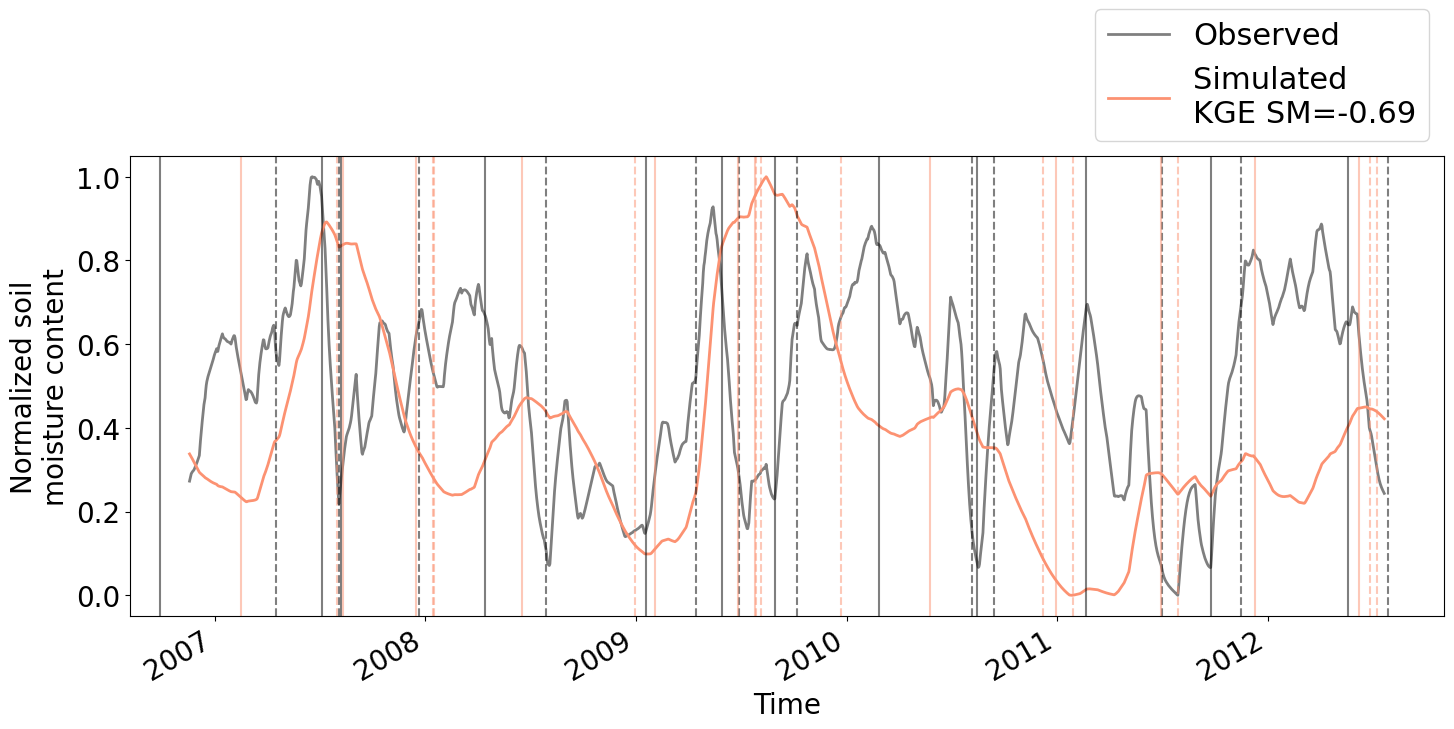

In [49]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(15, 8))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = (sig_obs.tt.values-min(sig_obs.tt.values))/(max(sig_obs.tt.values)-min(sig_obs.tt.values))
x_sim = sig_sim.tt.index
y_sim = (sig_sim.tt.values-min(sig_sim.tt.values))/(max(sig_sim.tt.values)-min(sig_sim.tt.values))
xlim_start = 60
xlim_end = len(x_obs)-60
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)
for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Normalized soil\nmoisture content')
# ax3.set_title(title)
ax3.legend(loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')

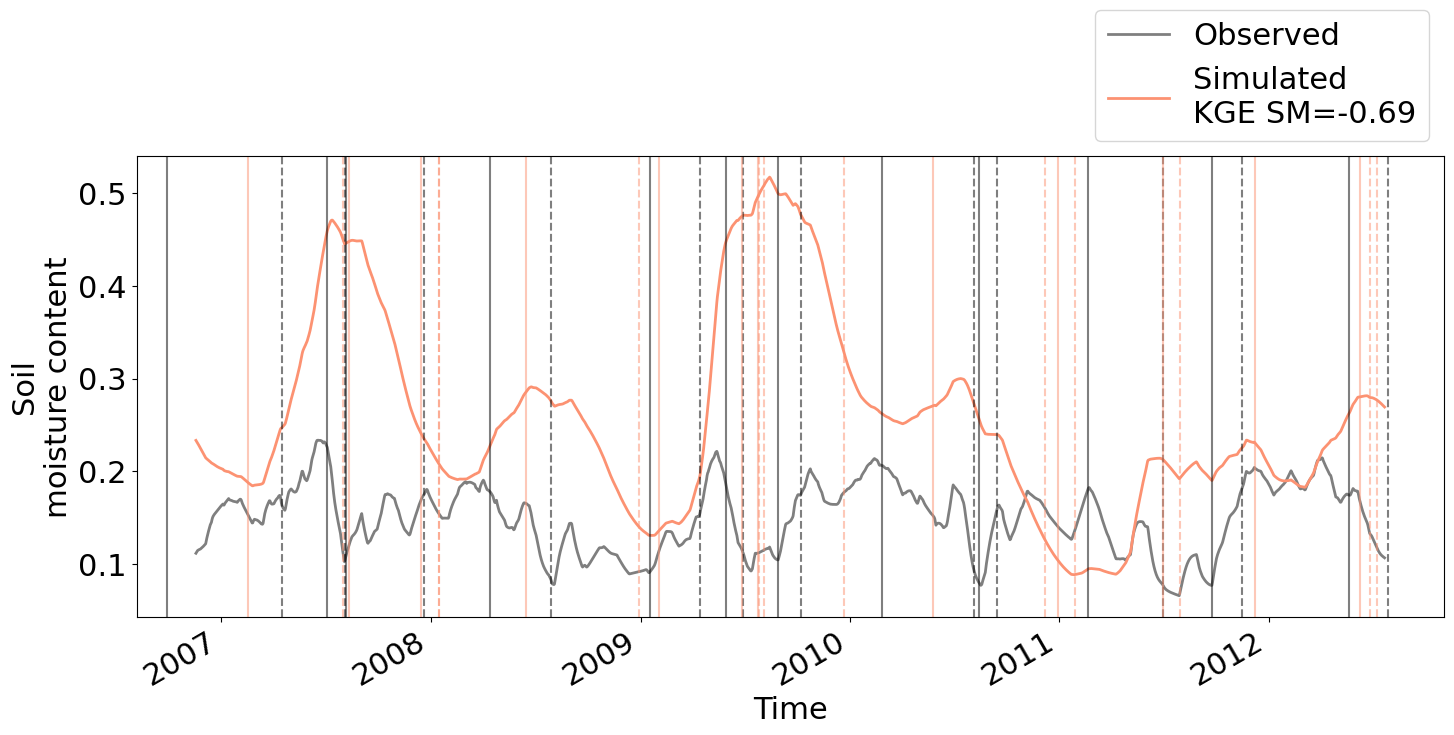

In [50]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(15, 8))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = sig_obs.tt.values
x_sim = sig_sim.tt.index
y_sim = sig_sim.tt.values
xlim_start = 60
xlim_end = len(x_obs)-60
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)
for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Soil\nmoisture content')
# ax3.set_title(title)
ax3.legend(loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')